# Phase 3 Project
- author: Jonathan Holt
- Flatiron Data Science
- 7/19/21 Cohort

## Business Problem

SyriaTel is a telecomunications company that is concerned with the amount of customers that are leaving their service. (ie, Churn). They have provided a dataset of their most recent data which has 14.5% of the customers leaving during the time period captured in the dataset. I have been tasked with analyzing the data and looking for any areas where Churn is significant, and make recommendations as to what SyriaTel can do to greatly reduce the rate of churn in its customers.

## The Data

The dataset that I was given to work with contains information for 3333 accounts, including:
- State
- Account Length
- Area Code
- Phone Number
- Extra Plans (VoiceMail and/or International)
- Minutes Used (Day, Evening, Night, International)
- Number of Calls (Day, Evening, Night, International)
- Number of VoiceMail Messages
- Total Amount Charged for minutes used (Day, Evening, Night, International)
- Number of calls to Customer Service

and most importantly:
- Churn: Customers who cancelled their service.

## Questions to Answer
1. What is the Baseline Churn Rate?
2. What factors contribute to churn?
3. What factors have the biggest impact on churn?
4. What can be done to identify when a customer is at risk for churn?
5. What can be done to prevent churn?

## What I am going to be looking for in my models:
1. <b>High Recall Score:</b> I want my model to be able to predict which customers are at risk of churning. If it is tuned to be too sensitive in this area, that is fine. I would rather flag customers that aren't going to churn rather than focus on the customers that are likely to stay, and ending up with unexpected churn. I will keep this in balance by checking F1 Score.

2. <b>Good F1 Score:</b>While I am ultimately not concerned with Precision (how well the model predicts customers that will stay), a good F1 score means that the model is performing well on both Recall and Precision. Since Recall and Precision are inverses of each other, a good F1 score ensures that the model isn't skewed too far toward one or the other. (ie, a model that predicts EVERY customer will churn would have perfect Recall, but would be useless).

3. <b>High Cross Validation Score:</b> This ensures that the model isn't overly trained on the test data and that it does a good job of predicted unseen and unknown data. (ie, the test set).

4. <b>Area Under the Curve (AUC):</b> The ROC AUC Score measures the Area under the ROC curve, which means that it classifies the true positive rate against the false positive rate. The higher the score, the better performing the model is. That said, here is the scale that I will use to evaluate my models:
- <u><b>.69 or less:</u></b> Model performs only slightly better than guessing and is worthless for my analysis.
- <u><b>.70 - .79:</u></b> Model still isn't performing very well, but is at minimum acceptable levels.
- <u><b>.80 - .89:</u></b> Model is performing fairly well. My goal is to be in this range or better.
- <u><b>.90 - .99:</u></b> Model is performing very well. I would be very happy to have a final model in this range.

# Data Preparation

## Importing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Fixing column names

In [4]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

## Inital Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [6]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [7]:
df.phone_number.duplicated().sum()

0

In [11]:
df.churn.value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [12]:
df2 = df2[['international_plan', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 
          'customer_service_calls', 'total_day_minutes', 'total_day_charge', 'churn']]

In [13]:
df2.groupby('international_plan').sum()

,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_day_minutes,total_day_charge,churn
international_plan,,,,,,,
no,30688.0,13441,8287.37,4736,538470.6,91541.61,346
yes,3432.9,1489,926.98,473,60719.8,10322.56,137


In [14]:
df2.sort_values('total_intl_calls', ascending=False).head(999)

,international_plan,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_day_minutes,total_day_charge,churn
3291,yes,13.9,20,3.75,1,172.1,29.26,True
22,no,9.5,19,2.57,0,183.0,31.11,False
982,no,13.0,18,3.51,1,159.1,27.05,False
2956,no,8.6,18,2.32,1,81.6,13.87,False
377,no,6.7,18,1.81,1,205.7,34.97,False
3310,no,13.6,17,3.67,2,190.4,32.37,False
2621,no,7.5,16,2.03,4,207.5,35.28,False
1567,no,15.6,16,4.21,0,85.9,14.60,False
1392,no,4.5,15,1.22,3,269.7,45.85,True
636,no,9.2,15,2.48,1,150.7,25.62,False


In [15]:
df.sort_values('total_intl_calls', ascending=False).head(999)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
3291,MI,119,510,335-7324,yes,yes,22,172.1,119,29.26,...,133,19.01,150.0,94,6.75,13.9,20,3.75,1,True
22,AZ,130,415,358-1958,no,no,0,183.0,112,31.11,...,99,6.20,181.8,78,8.18,9.5,19,2.57,0,False
982,ND,84,415,400-7253,no,yes,33,159.1,106,27.05,...,101,12.73,213.4,108,9.60,13.0,18,3.51,1,False
2956,NM,112,415,354-5764,no,no,0,81.6,94,13.87,...,112,22.79,140.8,75,6.34,8.6,18,2.32,1,False
377,ND,79,408,363-3515,no,no,0,205.7,123,34.97,...,108,18.23,226.1,106,10.17,6.7,18,1.81,1,False
3310,NY,94,415,363-1123,no,no,0,190.4,91,32.37,...,107,7.82,224.8,108,10.12,13.6,17,3.67,2,False
2621,MO,84,415,406-8665,no,yes,35,207.5,138,35.28,...,116,17.09,164.5,107,7.40,7.5,16,2.03,4,False
1567,WV,94,415,353-2080,no,no,0,85.9,113,14.60,...,91,19.27,279.6,110,12.58,15.6,16,4.21,0,False
1392,OK,101,415,413-4040,no,no,0,269.7,85,45.85,...,86,17.65,214.2,107,9.64,4.5,15,1.22,3,True
636,KS,121,408,373-5438,no,no,0,150.7,105,25.62,...,133,16.77,169.0,116,7.61,9.2,15,2.48,1,False


In [16]:
df.total_intl_calls.value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total_intl_calls, dtype: int64

In [17]:
intl_calls = df.total_intl_calls.value_counts().reset_index()
intl_calls

,index,total_intl_calls
0,3,668
1,4,619
2,2,489
3,5,472
4,6,336
5,7,218
6,1,160
7,8,116
8,9,109
9,10,50


In [18]:
intl_calls.head(2)

,index,total_intl_calls
0,3,668
1,4,619


In [19]:
intl_calls = intl_calls.rename(columns={"index": "#_of_intl_calls", "total_intl_calls": "#_of_accounts"})
intl_calls

,#_of_intl_calls,#_of_accounts
0,3,668
1,4,619
2,2,489
3,5,472
4,6,336
5,7,218
6,1,160
7,8,116
8,9,109
9,10,50


In [20]:
df.groupby('international_plan').mean()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
international_plan,,,,,,,,,,,,,,,,,
no,100.742193,436.508638,8.059801,178.893887,100.410963,30.412495,200.663090,100.074419,17.056565,201.350831,100.027907,9.060877,10.195349,4.465449,2.753279,1.573422,0.114950
yes,104.071207,443.461300,8.464396,187.986997,100.665635,31.958390,203.936842,100.486068,17.334923,196.410217,100.851393,8.838483,10.628173,4.609907,2.869907,1.464396,0.424149


## Initial Analysis

### Base Churn Rate: 14.49%
- There are 3333 records.
- No missing values, and no duplicates.
- The number of customers who churned was 483.
- Therefore the base churn rate is (483 / 3333) = 14.49%

### Target Feature Class Imbalance
- Churn is very imbalanced as the amount of customers who stay with the company is nearly 6X higher than the number of customers who leave.
- Class imbalance will need to be addressed in my models through one of (or a combination of) these options:
1. class weight parameters
2. oversampling or undersampling
3. Synthetic Minority Oversampling (SMOTE)

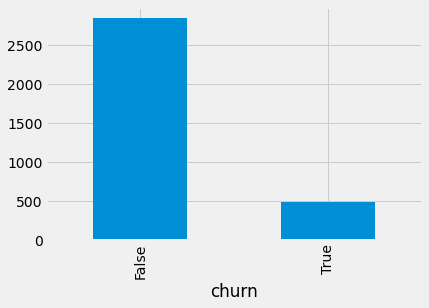

In [21]:
imbalance_data = df.pivot_table(index='churn', aggfunc='size').plot(kind='bar')
imbalance_data;

<AxesSubplot:xlabel='international_plan'>

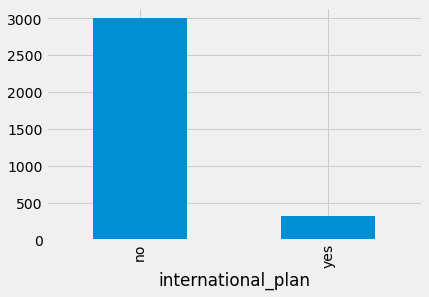

In [122]:
another_variable = df.pivot_table(index='international_plan', aggfunc='size').plot(kind='bar')
another_variable

# Cleaning and Preprocessing

In [22]:
test_df = df.copy()
test_df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Changing False to 0 and True to 1

In [23]:
test_df["churn"] = test_df["churn"].astype(int)
test_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

## Dropping Uneccesary Columns

In [24]:
test_df = test_df.drop(columns=['state','phone_number', 'area_code'], axis=1)
#test_df = test_df.drop(columns=['international_plan'], axis=1)

## Adding Column: Total Charge
- This column captures the total charge that the customer will see on their bill from all charges contained within the dataset.

In [25]:
total_charge = test_df.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
test_df['total_charge']= total_charge

## Slicing out object type Features

In [26]:
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]
feature_df = test_df.loc[:, cont_features]
feature_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09


## One Hot Encoding

In [27]:
need_to_encode = test_df[['international_plan', 'voice_mail_plan', 'customer_service_calls']]
#need_to_encode = test_df[['voice_mail_plan', 'customer_service_calls']]
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Combining everything together
cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
cleaned_df.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Metrics Function

In [29]:
def get_metrics(clf, y_pred):
    
    clf_acc = accuracy_score(y_test, y_pred) * 100
    print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    clf_rcl = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    

# Refining Data

In [30]:
cleaned_df_2 = cleaned_df.copy()
cleaned_df_2.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dropping Unecessary Columns

In [31]:
#cleaned_df_2 = cleaned_df_2.drop(columns=['area_code'], axis=1)

## Dropping one value for categoricals

In [32]:
#Dropping a few of the redundant values.
cleaned_df_2 = cleaned_df_2.drop(['international_plan_no', 'voice_mail_plan_no'], axis=1)
#cleaned_df_2 = cleaned_df_2.drop(['voice_mail_plan_no'], axis=1)
#cleaned_df_2.head(2)

## Creating Variable: Customer Service Calls High
- If Customer Service Calls High = 4 or more Customer Service Calls

In [33]:
#cs_calls_low = cleaned_df_2.apply(lambda x: x['customer_service_calls_0']+ x['customer_service_calls_1'] + x['customer_service_calls_2']
#                              + x['customer_service_calls_3'], axis=1)
cs_calls_high= cleaned_df_2.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
                              + x['customer_service_calls_6'] + x['customer_service_calls_7']
                            + x['customer_service_calls_8']+ x['customer_service_calls_9'], axis=1)

#cleaned_df['cs_calls_low'] = cs_calls_low
cleaned_df_2['cs_calls_high'] = cs_calls_high



In [34]:
cleaned_df_2 = cleaned_df_2.drop(['customer_service_calls_0', 'customer_service_calls_1','customer_service_calls_2','customer_service_calls_3',
                     'customer_service_calls_4','customer_service_calls_5','customer_service_calls_6',
                     'customer_service_calls_7','customer_service_calls_8','customer_service_calls_9']
                    , axis=1)
cleaned_df_2.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0,75.56,0.0,1.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0,59.24,0.0,1.0,0.0


In [35]:
#dropping cs_calls_low as it is redundant since this is now a binary choice.
#ohe_df = ohe_df.drop(['cs_calls_low', 'customer_service_calls_0'], axis=1)
#cleaned_df_2= cleaned_df_2.drop(['customer_service_calls_0'], axis=1)

In [36]:
total_charge = cleaned_df_2.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
cleaned_df_2['total_charge']= total_charge

## Creating Model DataFrame

In [37]:
model_df = cleaned_df_2.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_day_charge        3333 non-null   float64
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [38]:
model_df=model_df.drop(['customer_service_calls','total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
                           , axis=1)

In [39]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_eve_minutes       3333 non-null   float64
 5   total_eve_calls         3333 non-null   int64  
 6   total_night_minutes     3333 non-null   float64
 7   total_night_calls       3333 non-null   int64  
 8   total_intl_minutes      3333 non-null   float64
 9   total_intl_calls        3333 non-null   int64  
 10  churn                   3333 non-null   int64  
 11  total_charge            3333 non-null   float64
 12  international_plan_yes  3333 non-null   float64
 13  voice_mail_plan_yes     3333 non-null   float64
 14  cs_calls_high           3333 non-null   

## Dealing With Churn Class Imbalance 
- adding class weight Decision Tree Classifier
- Adding stratify to Test Train Split
- Adding SMOTE to Dataset.

In [40]:
balanced_df = model_df.copy()

X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

# Baseline Decision Tree 

In [41]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)

In [42]:
get_metrics(dt1, dt1_y_pred)

Accuracy is :93.5251798561151
Precision is :74.10071942446042
Recall is :85.12396694214877
F1 Score is :79.23076923076923
ROC AUC is :0.9


In [43]:
dt1_cv_score = np.mean(cross_val_score(dt1, X_train_resampled, y_train_resampled, cv=3))
dt1_cv_score

0.9536740258886919

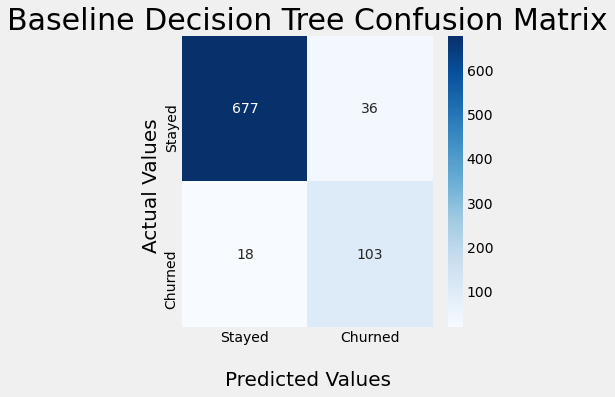

In [44]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Analysis:
- All of my work in preprocessing has paid off. The first model is already performing well.
- Recall is decent, F1 score is okay, and most importantly, ROC AUC score is in the highest range.
- Still, I will use GridSearch to further optimize my Decision Tree, and then use Random Forests to see if I can further refine and improve my model.

## Refining Decision Tree through GridSearchCV

In [45]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [47]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt1, dt_param_grid, cv=3, scoring = 'recall', return_train_score=True)
#dt3_grid_search = GridSearchCV(dt3, dt_param_grid, cv=3, scoring = 'f1', return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='recall')

In [48]:
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

# Decision Tree 2 (Using Grid Search Parameters)

In [ ]:
#dt2 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2,
#                             min_samples_leaf=1, class_weight='balanced', random_state=23)
#dt2.fit(X_train_resampled, y_train_resampled)
#dt2_y_pred = dt2.predict(X_test)

In [49]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)

In [51]:
get_metrics(dt2, dt2_y_pred)

Accuracy is :92.80575539568345
Precision is :71.03448275862068
Recall is :85.12396694214877
F1 Score is :77.4436090225564
ROC AUC is :0.9


In [52]:
# Mean training score
#dt2_ftraining_score = np.mean(dt2.cv_results_['mean_train_score'])

# Mean test score
#dt2_testing_score = dt2_grid_search.score(X_test, y_test)

#print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
#print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")

In [53]:
dt2_cv_score = np.mean(cross_val_score(dt2, X_train_resampled, y_train_resampled, cv=3))
dt2_cv_score

0.9525041067087193

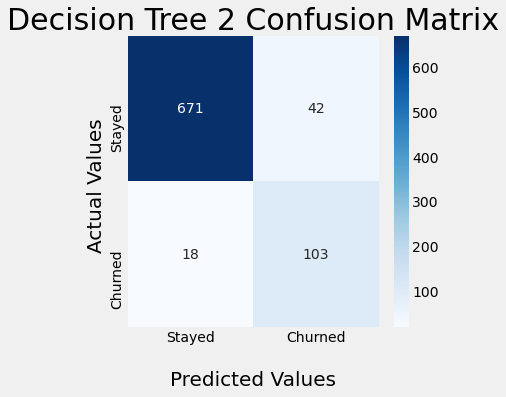

In [54]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Analysis:

In [55]:
# Mean training score
#dt1_gs_training_score = np.mean(dt3_grid_search.cv_results_['mean_train_score'])

# Mean test score
#dt3_gs_testing_score = dt3_grid_search.score(X_test, y_test)

#print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
#print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")


# Random Forests 1

In [56]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)

In [57]:
get_metrics(rf1_clf, rf1_y_pred)

Accuracy is :97.24220623501199
Precision is :96.22641509433963
Recall is :84.29752066115702
F1 Score is :89.86784140969164
ROC AUC is :0.92


In [58]:
rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train_resampled, y_train_resampled, cv=3))
rf1_cv_score

0.9723928970365989

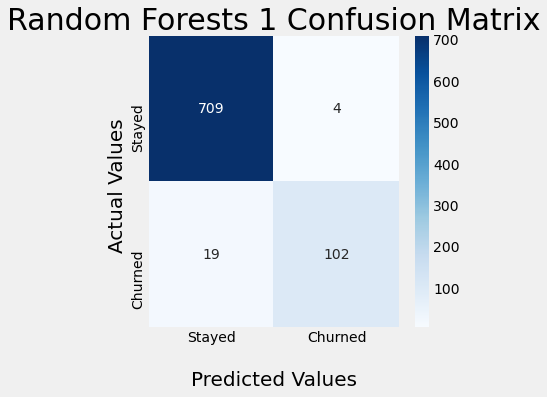

In [59]:
rf1_matrix = confusion_matrix(y_test, rf1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Random Forests 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Analysis
- My Random Forests model performs better than my Decision Trees in ROC AUC Score and F1 Score.
- The Recall Score is a slightly lower than my Decision Trees, but I hope that running a Grid Search will improve this score.

## GridSearch CV

In [62]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [66]:
#rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf1_grid_search = GridSearchCV(rf1_clf, rf_param_grid, scoring = 'recall', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

#print(f"Random Forest 2 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
#print("")
# Mean test score
#rf1_gs_testing_score = rf2_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}


# Random Forests 2 (Using Parameters from GridSearchCV)

In [69]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 100, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)

In [71]:
get_metrics(rf2_clf, rf2_y_pred)

Accuracy is :97.72182254196643
Precision is :98.11320754716981
Recall is :85.9504132231405
F1 Score is :91.62995594713657
ROC AUC is :0.93


In [72]:
rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train_resampled, y_train_resampled, cv=3))
rf2_cv_score

0.9672462054011434

In [73]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

print(rf2_matrix)

[[711   2]
 [ 17 104]]


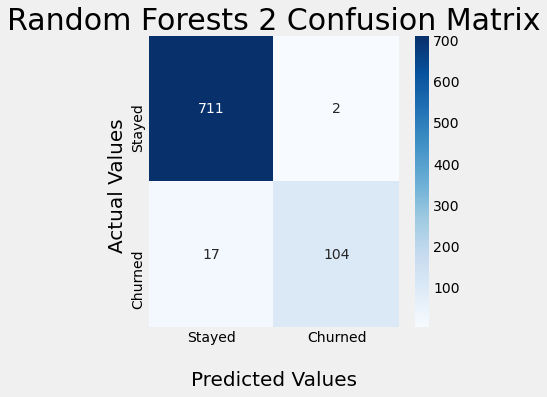

In [74]:

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d' )

ax.set_title('Random Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Analysis:
- While all 4 of my models performed well, this is my best performing model.
- Random Forests 2 performs best in all 3 key metrics: Recall, F1 Score, and ROC AUC Score.
- It also performs well enough to be used as my final model. 

# Feature Importance

In [76]:
feature_names = list(X)
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'total_charge',
 'international_plan_yes',
 'voice_mail_plan_yes',
 'cs_calls_high']

In [77]:
rf2_importance = rf2_clf.feature_importances_
rf2_importance

array([0.02641298, 0.02968403, 0.09871663, 0.02117496, 0.04067069,
       0.02195229, 0.03260532, 0.01969683, 0.03708927, 0.03343801,
       0.25297085, 0.15050265, 0.04599859, 0.1890869 ])

In [78]:
feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
10,total_charge,0.252971
13,cs_calls_high,0.189087
11,international_plan_yes,0.150503
2,total_day_minutes,0.098717
12,voice_mail_plan_yes,0.045999
4,total_eve_minutes,0.040671
8,total_intl_minutes,0.037089
9,total_intl_calls,0.033438
6,total_night_minutes,0.032605
1,number_vmail_messages,0.029684


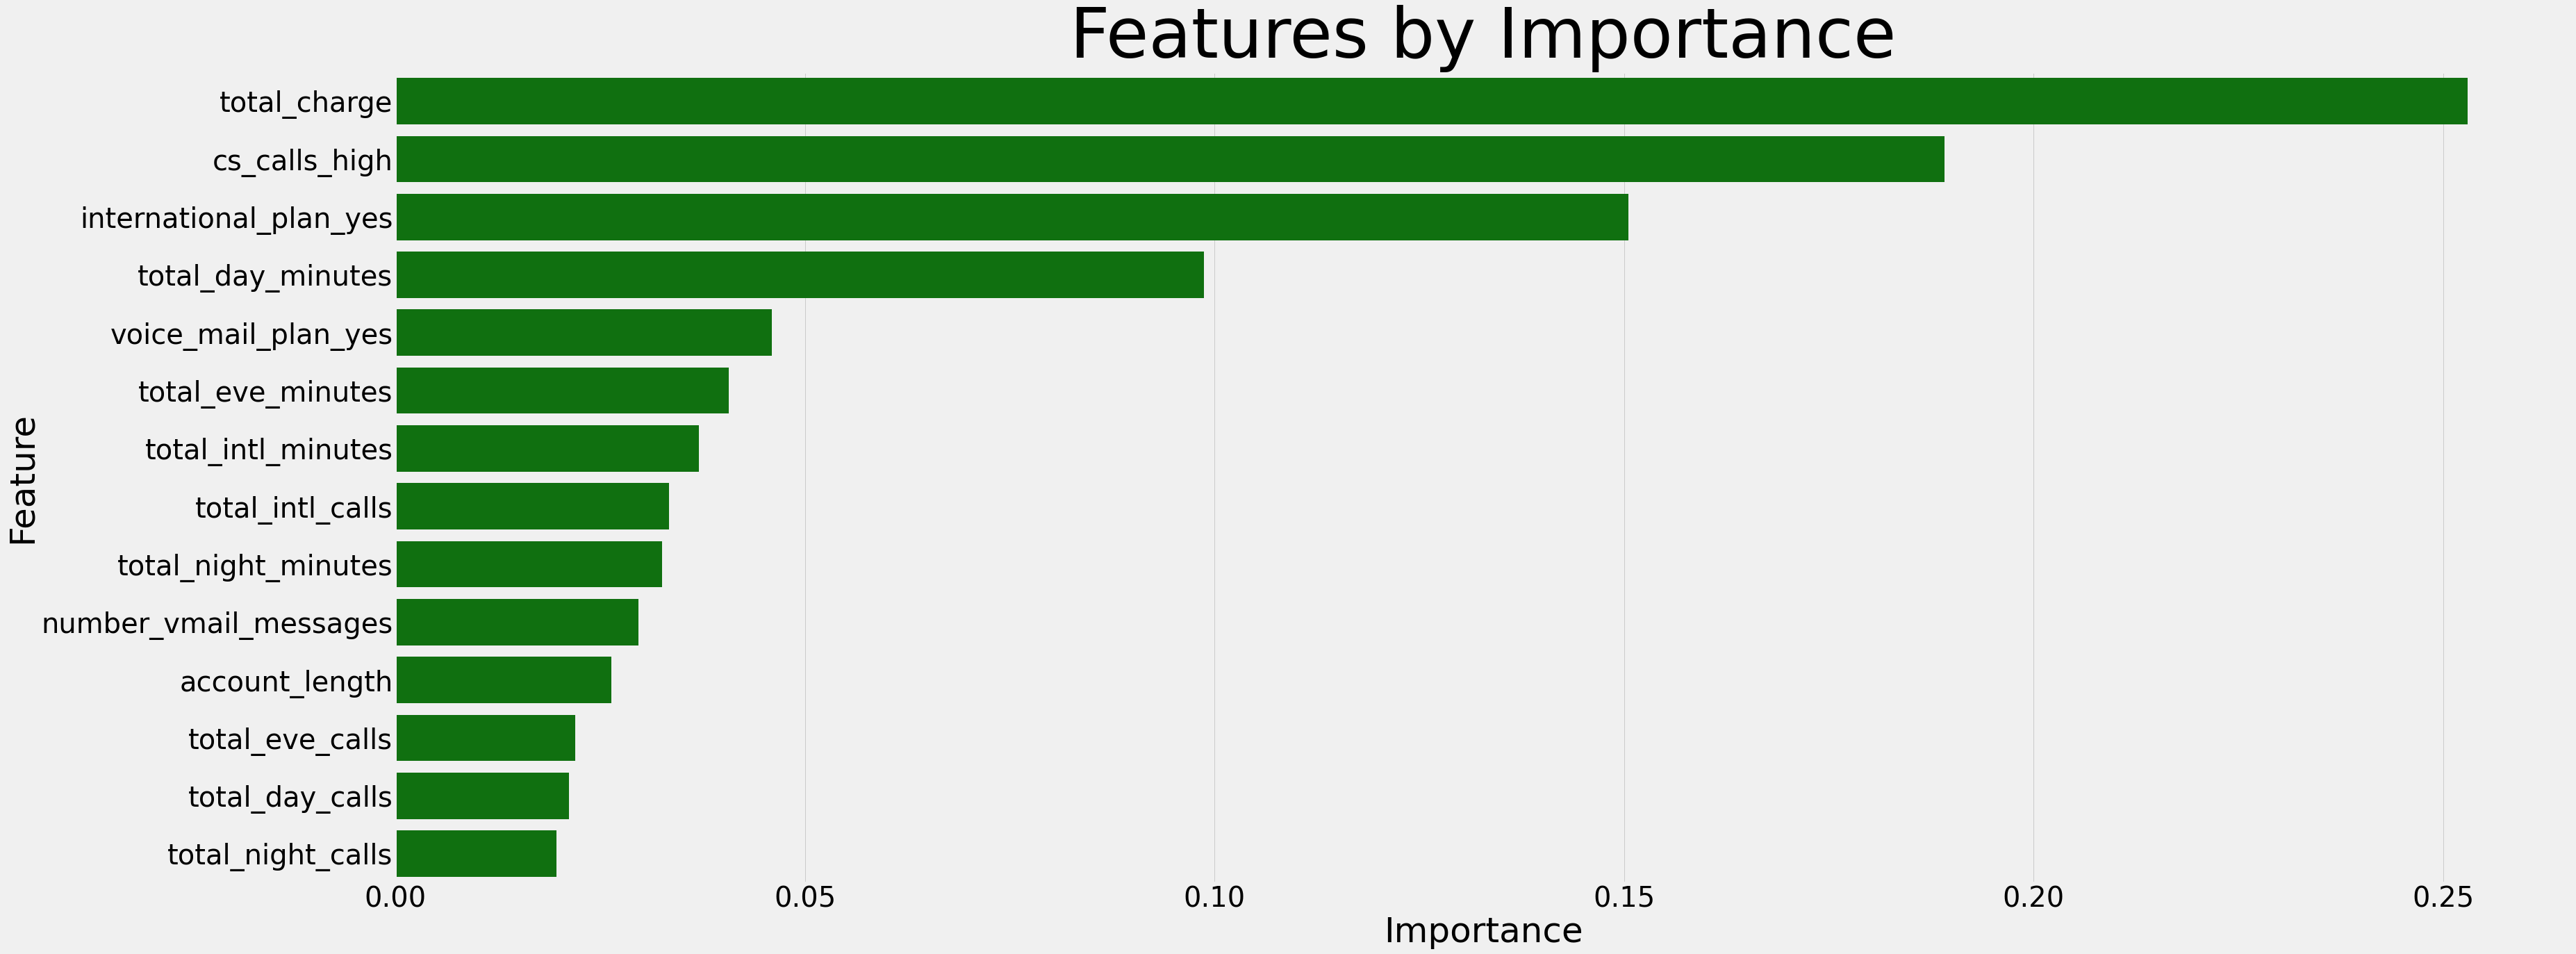

In [79]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
#p = sns.barplot(data=feature_importance_df, x='Feature', y='Importance' );
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='Green' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#p.yaxis.set_major_formatter(display_millions)
p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 
#plt.savefig('images/project_1_bar_3')

plt.show();

## Analysis
- Figure out how to rank feature importance as this is the ultimate outcome for my business problem.
- VISUALIZE!!!!

# Analyzing Churn Rate in Important Features

## Customer Service Calls

In [81]:
#cleaned_df.info()

In [82]:
analysis_df = cleaned_df.copy()

In [83]:
df.customer_service_calls.describe()

count    3333.000000
mean        1.562856
std         1.315491
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: customer_service_calls, dtype: float64

In [84]:
cs_churn_df = analysis_df.groupby('customer_service_calls')['churn'].sum().reset_index()
cs_churn_df = cs_churn_df.rename(columns={"customer_service_calls": "#_of_calls"})
variable_1 = analysis_df['customer_service_calls'].value_counts().reset_index()
variable_1 = variable_1.rename(columns={"index": "#_of_calls", "customer_service_calls": "#_of_accounts"})
cs_churn_df = cs_churn_df.merge(variable_1, on='#_of_calls')
churn_rate = cs_churn_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
cs_churn_df['churn_rate']= churn_rate
cs_churn_df

,#_of_calls,churn,#_of_accounts,churn_rate
0,0,92,697,0.131994
1,1,122,1181,0.103302
2,2,87,759,0.114625
3,3,44,429,0.102564
4,4,76,166,0.457831
5,5,40,66,0.606061
6,6,14,22,0.636364
7,7,5,9,0.555556
8,8,1,2,0.500000
9,9,2,2,1.000000


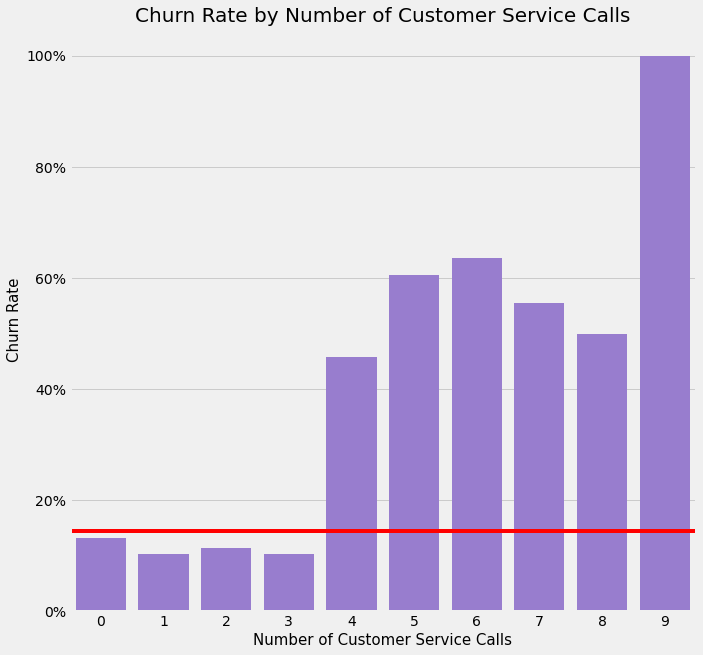

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="#_of_calls", y="churn_rate", data=cs_churn_df, color='mediumpurple');

p.set_xlabel("Number of Customer Service Calls", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
#p.xaxis.set_major_formatter(display_millions)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
p.set_title("Churn Rate by Number of Customer Service Calls", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=.145, color='red')
#plt.savefig('images/project_1_scatter_1')

plt.show();

### Analysis:
- There is a very strong relationship between the number of Customer Service Calls and Churn Rate.
- If there are 0-3 calls, those customers are below the avg. churn rate.
- At 4 Calls, the Churn Rate jumps to 45.7%, 4X the avg. churn rate.
- The Mode for Customer Service Calls is 1, with 2 or more calls being in the top quartile.
- Over Half of all customers make 1 or less customer service calls. (1878 of 3333: 56%)
- Hypothesis is that customers that are unhappy (and therefore more likely to cancel their service) are calling customer service more often.

## International Plan

In [86]:
#intl_df = analysis_df[['international_plan_yes', 'international_plan_no', 'total_intl_calls',
#                       'total_intl_charge', 'total_intl_minutes','churn', 'total_charge']]

In [87]:
intl_df = analysis_df[['international_plan_yes', 'international_plan_no', 'churn']]
intl_churn_df = intl_df.groupby('churn').sum().reset_index()
intl_churn_df = intl_churn_df.transpose()
intl_churn_df = intl_churn_df.rename(columns={0: "stayed", 1: "churned"})
intl_churn_df['total'] = intl_churn_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)
intl_churn_df['churn_rate'] = intl_churn_df.apply(lambda x: x['churned'] / x['total'], axis=1)
intl_churn_df

,stayed,churned,total,churn_rate
churn,0.0,1.0,1.0,1.000000
international_plan_yes,186.0,137.0,323.0,0.424149
international_plan_no,2664.0,346.0,3010.0,0.114950


In [88]:
df2 = df.copy()
df2 = df2[['international_plan', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 
          'customer_service_calls', 'total_day_minutes', 'total_day_charge', 'churn']]
df2.sort_values('total_intl_calls', ascending=False).head(999)

,international_plan,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_day_minutes,total_day_charge,churn
3291,yes,13.9,20,3.75,1,172.1,29.26,True
22,no,9.5,19,2.57,0,183.0,31.11,False
982,no,13.0,18,3.51,1,159.1,27.05,False
2956,no,8.6,18,2.32,1,81.6,13.87,False
377,no,6.7,18,1.81,1,205.7,34.97,False
3310,no,13.6,17,3.67,2,190.4,32.37,False
2621,no,7.5,16,2.03,4,207.5,35.28,False
1567,no,15.6,16,4.21,0,85.9,14.60,False
1392,no,4.5,15,1.22,3,269.7,45.85,True
636,no,9.2,15,2.48,1,150.7,25.62,False


In [89]:
df2.groupby('international_plan').mean()

,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_day_minutes,total_day_charge,churn
international_plan,,,,,,,
no,10.195349,4.465449,2.753279,1.573422,178.893887,30.412495,0.114950
yes,10.628173,4.609907,2.869907,1.464396,187.986997,31.958390,0.424149


### Analysis:
- NOTE: Data shows that Customers without the international plan were still able to make international calls. I am operating under the assumption that the data is correct and that there is a seperate International Plan, as indicated bty the "International Plan" column. I am also assuming that the data contained in that field is accurate. 
- only 323 people (9.5% of customers) have international plans. But those that do have a high rate of churn.
- churn rate for customers with an international plan is 42.4% vs 11.5% for those without an international plan.
- nearly 4X increase in churn rate.
- customers without an international plan are actually under the avg. churn rate, but remain fairly close.

## VM Plan

In [124]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            3333 non-null   int64  
 1   number_vmail_messages     3333 non-null   int64  
 2   total_day_minutes         3333 non-null   float64
 3   total_day_calls           3333 non-null   int64  
 4   total_day_charge          3333 non-null   float64
 5   total_eve_minutes         3333 non-null   float64
 6   total_eve_calls           3333 non-null   int64  
 7   total_eve_charge          3333 non-null   float64
 8   total_night_minutes       3333 non-null   float64
 9   total_night_calls         3333 non-null   int64  
 10  total_night_charge        3333 non-null   float64
 11  total_intl_minutes        3333 non-null   float64
 12  total_intl_calls          3333 non-null   int64  
 13  total_intl_charge         3333 non-null   float64
 14  customer

In [130]:
vm_df = analysis_df[['voice_mail_plan_yes', 'number_vmail_messages', 'churn']]
vm_df = vm_df.groupby('churn').sum().reset_index()
vm_df = vm_df.transpose()
vm_df = vm_df.rename(columns={0: "stayed", 1: "churned"})
vm_df['total'] = vm_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)
vm_df['churn_rate'] = vm_df.apply(lambda x: x['churned'] / x['total'], axis=1)
vm_df

,stayed,churned,total,churn_rate
churn,0.0,1.0,1.0,1.000000
voice_mail_plan_yes,842.0,80.0,922.0,0.086768
number_vmail_messages,24523.0,2471.0,26994.0,0.091539


## Total Charge

In [90]:
analysis_df['total_charge'].describe()

count    3333.000000
mean       59.449754
std        10.502261
min        22.930000
25%        52.380000
50%        59.470000
75%        66.480000
max        96.150000
Name: total_charge, dtype: float64

In [91]:
charge_df = analysis_df[['total_charge', 'churn']]

In [92]:
charge_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 200)

<ipython-input-92-8e20f0b683f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 200)


In [93]:
charge_df

,total_charge,churn,charge_group
0,75.56,0,"(75.267, 75.632]"
1,59.24,0,"(59.097, 59.337]"
2,62.29,0,"(62.199, 62.34]"
3,66.80,0,"(66.633, 66.8]"
4,52.09,0,"(51.93, 52.11]"
...,...,...,...
3328,60.10,0,"(60.05, 60.153]"
3329,63.53,0,"(63.476, 63.569]"
3330,67.74,0,"(67.692, 67.843]"
3331,57.53,0,"(57.51, 57.61]"


In [94]:
group_counts = charge_df.charge_group.value_counts().reset_index()

In [95]:
group_counts = group_counts.rename(columns={"index": "charge_group", "charge_group": "#_of_accounts"})

In [96]:
charge_df= charge_df.groupby('charge_group').mean()
charge_df= charge_df.rename(columns={'total_charge': 'group_mean'})
charge_df


,group_mean,churn
charge_group,,
"(22.929, 32.497]",28.372353,0.235294
"(32.497, 33.853]",33.329412,0.117647
"(33.853, 35.72]",34.832500,0.062500
"(35.72, 37.436]",36.645882,0.058824
"(37.436, 38.752]",38.102941,0.000000
"(38.752, 39.44]",39.101875,0.187500
"(39.44, 40.212]",39.834118,0.176471
"(40.212, 41.033]",40.572353,0.117647
"(41.033, 41.665]",41.304375,0.125000


In [97]:
charge_df = charge_df.reset_index()

In [98]:
charge_df = charge_df.merge(group_counts, on='charge_group')

In [99]:
charge_df

,charge_group,group_mean,churn,#_of_accounts
0,"(22.929, 32.497]",28.372353,0.235294,17
1,"(32.497, 33.853]",33.329412,0.117647,17
2,"(33.853, 35.72]",34.832500,0.062500,16
3,"(35.72, 37.436]",36.645882,0.058824,17
4,"(37.436, 38.752]",38.102941,0.000000,17
5,"(38.752, 39.44]",39.101875,0.187500,16
6,"(39.44, 40.212]",39.834118,0.176471,17
7,"(40.212, 41.033]",40.572353,0.117647,17
8,"(41.033, 41.665]",41.304375,0.125000,16
9,"(41.665, 42.338]",42.021176,0.000000,17


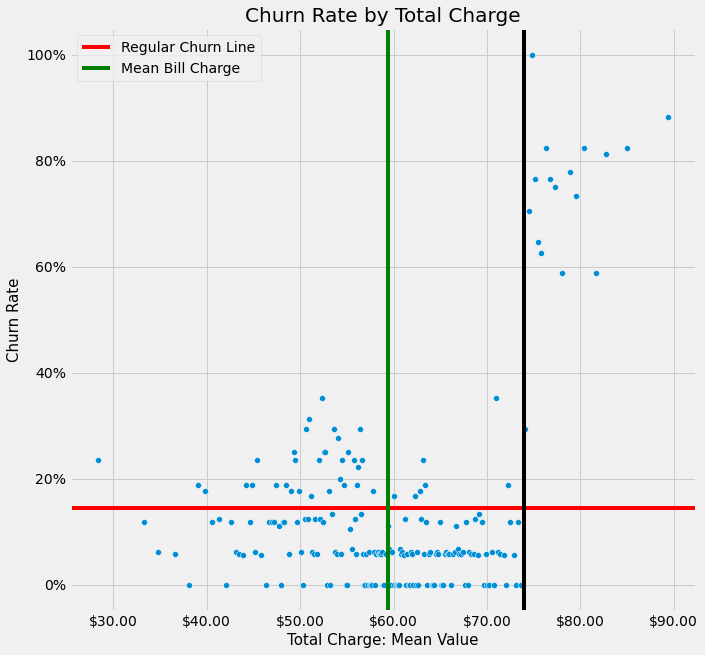

In [132]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="group_mean", y="churn", data=charge_df);

p.set_xlabel("Total Charge: Mean Value", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#p.xaxis.set_major_formatter(display_millions)
ax.xaxis.set_major_formatter('${x:1.2f}')

p.set_title("Churn Rate by Total Charge", fontsize = 20)
plt.figsize=(30,20) 

line_1 = plt.axhline(y=.145, color='red')
#line_2 = plt.axhline(y=.25, color='black')
line_3 = plt.axvline(x=59.45, color='green')
line_4 = plt.axvline(x=74.00, color='black')

ax.legend([line_1, line_3], ['Regular Churn Line', 'Mean Bill Charge'])
#plt.savefig('images/project_1_scatter_1')


plt.show();

### Analysis
- Total Charge of $74/month leads to Churn Rate of roughly 70% or greater!\
- This affects aprox 240 customers (15 groups of 16)
- While there a a good amount of customers above the average churn line, if you add a standard deviation of 10%, almost all are within that range until you get to the extreme outliers.

In [135]:
charge_df['churn'].()

count    200.000000
mean       0.144774
std        0.200564
min        0.000000
25%        0.055556
50%        0.062500
75%        0.176471
max        1.000000
Name: churn, dtype: float64

## Minutes

In [101]:
#analysis_df.info()

In [102]:
min_df=analysis_df.copy()

In [103]:
min_df = analysis_df[['total_day_minutes', 'churn']]

In [104]:
min_df['min_group'] = pd.qcut(min_df['total_day_minutes'], 200)

<ipython-input-104-e6304b436db0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_df['min_group'] = pd.qcut(min_df['total_day_minutes'], 200)


In [105]:
min_df['min_group'].value_counts().head()

(182.764, 183.4]    22
(190.69, 191.4]     21
(170.442, 171.2]    21
(238.052, 239.8]    21
(189.7, 190.3]      20
Name: min_group, dtype: int64

In [106]:
min_df.describe()

,total_day_minutes,churn
count,3333.000000,3333.000000
mean,179.775098,0.144914
std,54.467389,0.352067
min,0.000000,0.000000
25%,143.700000,0.000000
50%,179.400000,0.000000
75%,216.400000,0.000000
max,350.800000,1.000000


In [107]:
min_df = min_df.groupby('min_group').mean()

In [108]:
min_df

,total_day_minutes,churn
min_group,,
"(-0.001, 38.922]",20.300000,0.058824
"(38.922, 51.832]",46.735294,0.176471
"(51.832, 58.898]",55.906250,0.125000
"(58.898, 63.092]",61.282353,0.235294
"(63.092, 70.83]",67.729412,0.117647
"(70.83, 76.088]",73.012500,0.062500
"(76.088, 81.662]",79.123529,0.058824
"(81.662, 84.34]",82.888235,0.176471
"(84.34, 87.188]",85.850000,0.062500


In [109]:
min_df = min_df.rename(columns={"total_day_minutes": "group_mean"})

In [110]:
min_df = min_df.reset_index()

In [111]:
min_df

,min_group,group_mean,churn
0,"(-0.001, 38.922]",20.300000,0.058824
1,"(38.922, 51.832]",46.735294,0.176471
2,"(51.832, 58.898]",55.906250,0.125000
3,"(58.898, 63.092]",61.282353,0.235294
4,"(63.092, 70.83]",67.729412,0.117647
5,"(70.83, 76.088]",73.012500,0.062500
6,"(76.088, 81.662]",79.123529,0.058824
7,"(81.662, 84.34]",82.888235,0.176471
8,"(84.34, 87.188]",85.850000,0.062500
9,"(87.188, 89.92]",88.635294,0.235294


In [112]:
df.total_day_minutes.mean()

179.77509750975094

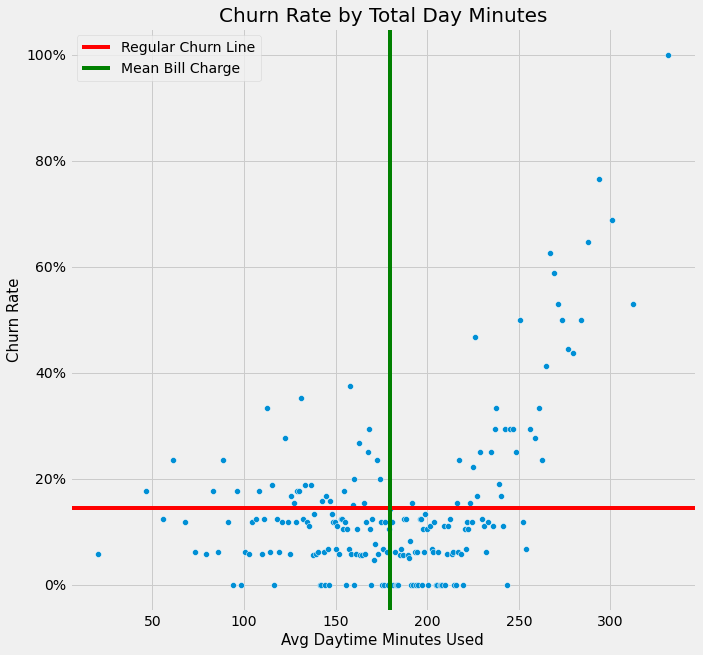

In [121]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,10))
p= sns.scatterplot(x="group_mean", y="churn", data=min_df);

p.set_xlabel("Avg Daytime Minutes Used", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#p.xaxis.set_major_formatter(display_millions)

p.set_title("Churn Rate by Total Day Minutes", fontsize = 20)
plt.figsize=(30,20) 

line_1 = plt.axhline(y=.145, color='red')
#line_2 = plt.axhline(y=.25, color='black')
#line_3 = plt.axvline(x=225, color='blue')
line_4 = plt.axvline(x=179.78, color='green')


ax.legend([line_1, line_4], ['Regular Churn Line', 'Mean Bill Charge'])
#plt.savefig('images/project_1_scatter_1')


plt.show();

### Analysis:
- FYI: Grouped into 200 groups of 20 or so records.
- Mean for Total Day Minutes is 179.77.
- Churn Rate (mostly) remains under the churn line until reaching 225 minutes.
- If you add an extra 10% to churn line, all of the groups (with one exception) remain under the churn line until reaching 225 minutes.
- At 225 minutes, the churn rate greatly increases.

In [114]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            3333 non-null   int64  
 1   number_vmail_messages     3333 non-null   int64  
 2   total_day_minutes         3333 non-null   float64
 3   total_day_calls           3333 non-null   int64  
 4   total_day_charge          3333 non-null   float64
 5   total_eve_minutes         3333 non-null   float64
 6   total_eve_calls           3333 non-null   int64  
 7   total_eve_charge          3333 non-null   float64
 8   total_night_minutes       3333 non-null   float64
 9   total_night_calls         3333 non-null   int64  
 10  total_night_charge        3333 non-null   float64
 11  total_intl_minutes        3333 non-null   float64
 12  total_intl_calls          3333 non-null   int64  
 13  total_intl_charge         3333 non-null   float64
 14  customer

# Conclusions

## Questions to Answer: Revisited
1. What is the Baseline Churn Rate?
2. What factors contribute to churn?
3. What factors have the biggest impact on churn?
4. What can be done to identify when a customer is at risk for churn?
5. What can be done to prevent churn?

### What is the Baseline Churn Rate?
- 14.49%
- This is the percentage of churn that occured in the dataset I was provided.

### What Factors Contribute to Churn? Which has the biggest impact?

In [115]:
feature_importance_df

,Feature,Importance
10,total_charge,0.252971
13,cs_calls_high,0.189087
11,international_plan_yes,0.150503
2,total_day_minutes,0.098717
12,voice_mail_plan_yes,0.045999
4,total_eve_minutes,0.040671
8,total_intl_minutes,0.037089
9,total_intl_calls,0.033438
6,total_night_minutes,0.032605
1,number_vmail_messages,0.029684


The 4 factors that have the biggest impact on Churn (in order) are:
- Total Amount Charged
- A High Number of Customer Service Calls.
- Customer having an international plan.
- Total Number of Minutes used during the day.

### What can be done to identify when a customer is at risk for churn?
- based on my analysis, here is where customers "cross the line" into being at a high risk for churn:
- Having a Total Charge of $74 or more.
- Calling Customer Service 4 or more times.
- Having an international plan.
- Using 225 or more Daytime Minutes.

# Recommendations

## Recommendation #1: Increased Focus on Customer Service.
- There is a sharp increase in Churn when a Customer reaches their 4th call to customer service. In order to retain more customers, <b>SyriaTel should focus on resolving whatever issues that customers bring up with Customer Service. If all questions are answered, and issues are explained and addressed, this should lead to happier customers, less customer service calls, and less churn.</b>
- Of course, the call itself isn't the issue. Customer service calls are a sign that something is wrong, and the more that a customer calls, the more likely they are to be having problems with the service and/or paying their bills.
- I recommend that SyriaTel analyze any data that they have on Customer Service calls to see what issues customers were bringing up and at what frequency. Proactively dealing with these issues will likely cause a decrease in churn.

## Recommendation #2: Set up a system which identifies when a customer is getting close to any of the thresholds identified above.
- Please Note: These recommenations are based on the way that everything is currently set up. If my other recommendations are followed, many of these issues would already be taken care of.

### Green: Low Risk of Customer Churn.
- 0-1 Customer Service Calls.
- Customer Bill is $60/month or less.
- Customer does not have International Plan.

### Yellow: Account is begining to show warning signs of churn. 
- 2-3 Customer Service Calls
- Customer Bill is above $60/month (the mean value)

### Red: Account is at high risk of churn.
- 4 or more Customer Service Calls
- Customer Monthly Bill is at $74 or higher.
- Customer has International Plan (in it's current form. See Recommendation #4)
- Customer has used 225 or more minutes in a month.

## Recommendation #3: Offer a Flat Price Model to Combat High Customer Charges
- Making more money is good, but there the HIGHEST correlation with churn comes from high charge, and high minutes. This indicates that customers are being charged per minute. SyriaTel would ultimately make MORE money by RETAINING the customers that they already have.
- By charging a flat fee, it eliminates any surprise that the customer has, which should result in less customer service calls, and less churn.
- The flat fee could be offered in tiers.
- The point of this recommendation is that customers know how much their bill is each month, even if they go over on minutes, etc.

## Recommendation #4: Take a good look at your international plan and see why it increases the amount of Churn

- Customers without the international plan are able to make international calls.
- Customers with the international plan end up leaving. 
- I don't have data on how much the international plan costs or how it is used, but it is causing higher churn.
- Perhaps it costs too much, or doesn't give an advantage over not having the plan, or is inferior to the competition.

# Summary

In [116]:
final_analysis_df = analysis_df[['international_plan_yes', 'total_intl_minutes', 'total_intl_calls',
                    "total_intl_minutes", 'total_day_minutes', 'total_charge', 'customer_service_calls',
                     'churn']]

In [137]:
final_analysis_df.groupby('churn').mean()

,international_plan_yes,total_intl_minutes,total_intl_calls,total_intl_minutes,total_day_minutes,total_charge,customer_service_calls
churn,,,,,,,
0,0.065263,10.158877,4.532982,10.158877,175.175754,58.448807,1.449825
1,0.283644,10.700000,4.163561,10.700000,206.914079,65.355963,2.229814


# Archive